In [1]:
#important import libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import glob as gb
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# for unzip Folder
!unzip "/content/drive/MyDrive/DatasetProcessed.zip" -d "/content/"
clear_output()

In [4]:
#Useful imports
#will remain the same
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

np.random.seed(42)
tf.random.set_seed(42)

In [5]:
root_img='/content/DatasetProcessed/Total Images'
root_txt='/content/DatasetProcessed/Total GT'
filenames_img=sorted(os.listdir(root_img))
filenames_gt=sorted(os.listdir(root_txt))
filenames_imgsplit=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

5161
5161


In [6]:
#train test validate splitting
split_idx = int(0.8 * len(filenames_imgsplit))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
validation_samples_split = test_samples_split[:val_split_idx]
test_samples = test_samples[val_split_idx:]
test_samples_split = test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f' Example from training dataset {train_samples_split[100]}')

Total training samples: 4128
Total validation samples: 516
Total test samples: 517
 Example from training dataset AHTD3A0003_Para4_4_word9


In [7]:
#get data and labels as lists
base_path='/content/'
base_image_path = os.path.join(base_path, "DatasetProcessed/Total Images/")
base_GT_path = os.path.join(base_path, "DatasetProcessed/Total GT/")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(
            base_image_path ,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_GT_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r")
        labels.append(label_file.read())

    return paths, labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

In [11]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set() #to Take unique elements
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  7
Vocab size:  39


['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م']

In [16]:
#strip() function=>>If the developer specifies a set of characters as an argument to the strip() function, it removes
# those characters or symbols from the beginning and the end of the string to return the original string

#split() function breaks up a string to return the list of all strings


b=set()
l='!بسم الله الرحمن الرحيم وبعد نحن طلاب جامعة تعز كلية الهندسة قسم تقنية المعلومات نحاول جاهدين عمل مشروع التعرف على خط اليد باللغة العربية'
m=l.split(' ')
for i in l:
  h=i.split(" ")[-1].strip()
  for ch in h:
    b.add(ch)

print(b)
print('\n',m[:5])
print('\n',m)



{'خ', 'ت', 'ك', 'ز', 'ق', 'ش', 'ا', 'ر', 'ط', 'د', 'ف', 'ة', '!', 'غ', 'ب', 'ج', 'ع', 'ى', 'ح', 'ي', 'ل', 'و', 'م', 'ه', 'س', 'ن'}

 ['!بسم', 'الله', 'الرحمن', 'الرحيم', 'وبعد']

 ['!بسم', 'الله', 'الرحمن', 'الرحيم', 'وبعد', 'نحن', 'طلاب', 'جامعة', 'تعز', 'كلية', 'الهندسة', 'قسم', 'تقنية', 'المعلومات', 'نحاول', 'جاهدين', 'عمل', 'مشروع', 'التعرف', 'على', 'خط', 'اليد', 'باللغة', 'العربية']


In [17]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [18]:
print(characters)

{'خ', '،', 'ت', 'ك', 'ث', 'ز', 'ق', 'ش', 'ا', 'ذ', '.', 'ر', 'ط', 'ٍ', 'د', 'ف', 'ة', 'ض', 'غ', 'أ', 'ب', 'ء', 'ص', 'ئ', 'إ', ':', 'ظ', 'ج', 'ع', 'ح', 'ي', 'ل', 'و', 'م', 'ؤ', 'ه', 'آ', 'س', 'ن'}


In [19]:
AUTOTUNE = tf.data.AUTOTUNE #To initial parameter AUTOTUNE with value(-1)

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [21]:
char_to_num.get_vocabulary()

['[UNK]',
 'خ',
 '،',
 'ت',
 'ك',
 'ث',
 'ز',
 'ق',
 'ش',
 'ا',
 'ذ',
 '.',
 'ر',
 'ط',
 'ٍ',
 'د',
 'ف',
 'ة',
 'ض',
 'غ',
 'أ',
 'ب',
 'ء',
 'ص',
 'ئ',
 'إ',
 ':',
 'ظ',
 'ج',
 'ع',
 'ح',
 'ي',
 'ل',
 'و',
 'م',
 'ؤ',
 'ه',
 'آ',
 'س',
 'ن']

In [22]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [23]:
print(train_labels_cleaned)

['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'بد', 'مظفر', 'نوح', 'ذهب', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'وهلال', 'عطعوط', 'وهو', 'و', 'طفنا', 'لنا', 'وصو', 'عند', '.', 'يلبي', 'آخر', 'ثر', 'إ', 'حاج', 'في', 'جاري', 'كان', '.', 'شيخ', 'مع', 'سعينا', '.', 'رايق', 'ي', 'لؤ', 'بن', '.', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'مظفر', 'للحج', 'نوح', 'هب', 'ذ', 'عفيف', 'خازن', 'ل', 'وهلا', 'عطعوط', 'فر', 'ظا', 'الخيمة', 'وصولنا', 'عند', '.', 'يلبي', 'آخر', 'إ', 'حاج', 'لحجيج', 'ا', 'قوافل', 'في', 'أت', 'بد', 'جاري', 'كان', '.', 'شيخ', 'مع', 'وسعينا', 'طفنا', '.', 'دراق', '،', 'مشمش', ':', 'لنص', 'ا', 'ا', 'لهذ', 'نسر', '،', 'بث', '،', 'ناء', '،', 'غيظ', '،', '.', 'نسر', '،', 'بث', '،', 'ء', 'نا', '،', 'غيظ', 'ط', 'و', 'ؤ', 'ر', '.', '.', 'بصحبة', 'م', 'غا', 'ضر', 'عطعو', 'مظفر', 'ح', 'نو', 'هب', 'ذ', 'ظافر', 'يق', 'ا', 'ر', 'ء', 'لؤ', 'بن', 'ت', 'أ', 'بد', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'ل', 'هلا', 'إ', 'ج', 'حا', 'لحجيج', 'أ', 'فل', 'ا', 'قو', 'سعينا', 'و', 'طفنا', 'ل

In [30]:
batch_size = 64
padding_token = 99
image_width = 64
image_height = 32

from pathlib import Path
import imghdr



def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 0)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    #print("The length of this label:",length)
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

label=vectorize_label(train_labels_cleaned[1])
print('vectorize_label=\n',label)
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")
print(label)

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    #return dataset
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



ظافر
vectorize_label=
 tf.Tensor([27  9 16 12 99 99 99], shape=(7,), dtype=int64)
ظافر


In [31]:
#The simplest way to create a dataset is to create it from a python list:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
  print(element)


# Dictionary structure is also preserved.
dataset = tf.data.Dataset.from_tensor_slices({"a": [1, 2], "b": [3, 4]})
list(dataset.as_numpy_iterator()) 
#The result of this equal
#[{'a': 1, 'b': 3},
#{'a': 2, 'b': 4}]

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


[{'a': 1, 'b': 3}, {'a': 2, 'b': 4}]

In [32]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


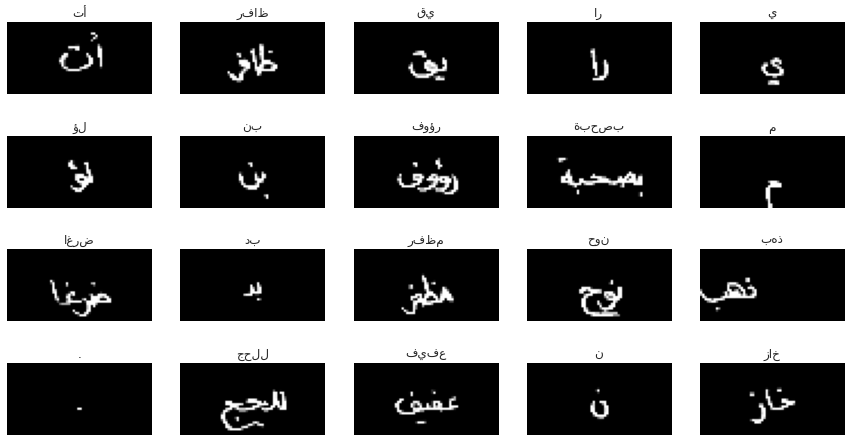

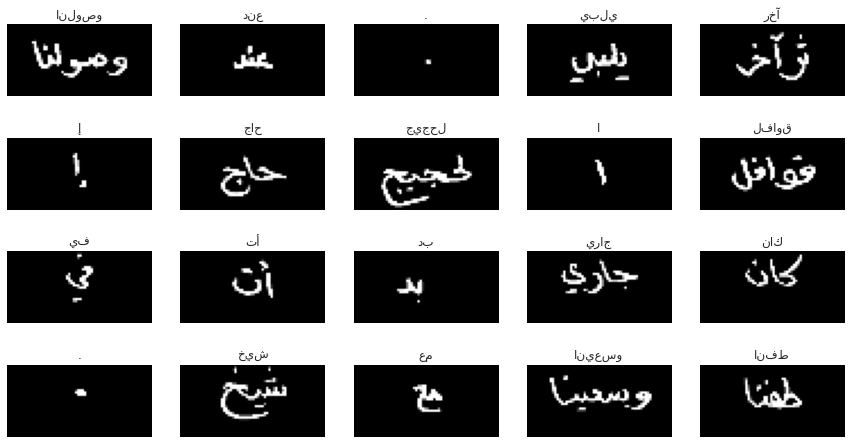

In [33]:
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 5, figsize=(15, 8))

    for i in range(20):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(label[::-1])  #[::-1] TO start order from end
        ax[i // 5, i % 5].axis("off")


plt.show()

In [34]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= keras.layers.BatchNormalization()(x)
    new_shape = ((image_width // 2), (image_height // 2) * 32)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(16, activation="relu", name="dense2")(x)
    x= keras.layers.BatchNormalization()(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)


    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 16, 32)  128         ['pool1[0][0]']                  
 alization)                                                                  

In [35]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [36]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.sparse.from_dense(labels)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = keras.backend.ctc_decode(
        
        predictions, input_length=input_len, greedy=False, beam_width=100,
    )[0][0][:, :max_len]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)
    
    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [52]:
epochs = 100  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
)

#add early stopping mechanism

Epoch 1/100
1/1 [==============================] - 1s 902ms/step
Mean edit distance for epoch 1: 6.8958
65/65 [==============================] - 38s 485ms/step - loss: 90.2477 - val_loss: 89.6265
Epoch 2/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 2: 6.9653
65/65 [==============================] - 22s 340ms/step - loss: 27.5257 - val_loss: 17.8481
Epoch 3/100
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 3: 6.9878
65/65 [==============================] - 22s 339ms/step - loss: 14.1542 - val_loss: 10.7983
Epoch 4/100
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 4: 6.9948
65/65 [==============================] - 23s 352ms/step - loss: 9.7523 - val_loss: 9.9255
Epoch 5/100
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 5: 6.9931
65/65 [==============================] - 21s 330ms/step - loss: 9.2632 - val_loss: 9.6542
Epoch 6/100
1/1 [===========

In [54]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    #print(results)
    return output_text


2/2 [==============================] - 0s 40ms/step
['ا', '', 'لما', 'ل', 'ا', '،', '', 'لا', '', 'ي', '', '', '،', '،', 'لا', 'ا', '', '', 'ا', 'ي', 'لا', '.', 'ي', 'وا', 'ا', '', 'ا', 'ا', '', 'لا', '،', '', '', '', '.', '،', 'ا', '', '', 'فا', 'ا', 'ل', 'لما', 'ا', '.', '', 'ا', '،', '،', 'عشة', '،', 'لا', 'ا', 'لا', '', '', 'لا', '،', '', '،', '،', 'ا', '،', 'ي']
False
True
False
False
False
False
True
False
True
False
True
True
False
False
False
False
True
True
False
False


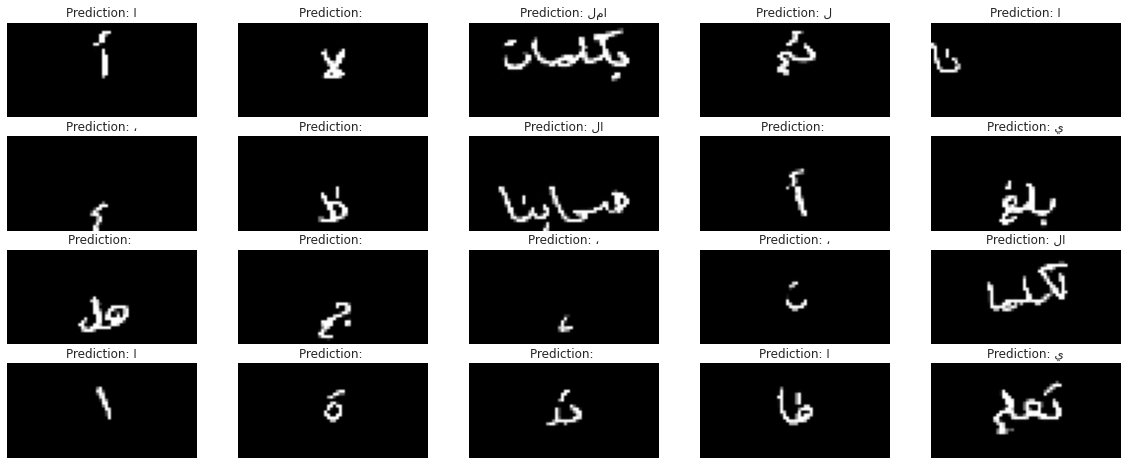

In [55]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 5, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(20):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        print(pred_texts[i]=='')
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(title)
        ax[i // 5, i % 5].axis("off")

plt.show()

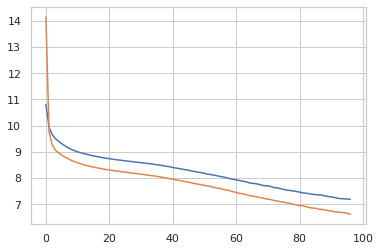

In [56]:
plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][2:len(history.history['loss'])-1])

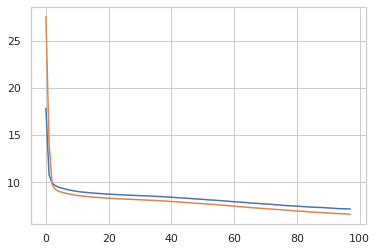

In [57]:
plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][1:len(history.history['loss'])-1])

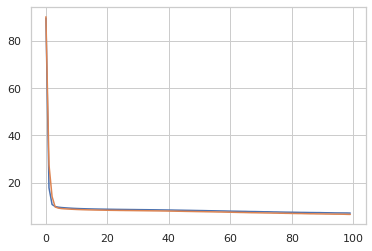

In [58]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])